# FOOD AND BEVERAGE BUSINESS OPPORTUNITY SEEKER

This is an independent project centered around data science application in food and beverage industry. 

## Table of Contents

1. Introduction
2. Data
3. Methodology
4. Let's Do This

	4.1. Web Scrapping
    
	4.2. Get Longitude and Latitude of Each Subdistrict
    
	4.3. Get List of Food Venues in Each Subdistrict
    
	4.4. Exploratory Data Analysis (EDA)
    
	4.5. Cluster All Subdistricts
    
		4.5.1. Data Preparation
		4.5.2. Clustering
		4.5.3. Cluster Visualization
		4.5.4. Cluster Analysis
        
5. Discussion
6. Conclusion
7. Future Direction

## 1. Introduction

Jakarta is Indonesia's massive capital. This city sits on the northwest coast of the island of Java. Indonesia is the largest economy of ASEAN, and Jakarta is the economic nerve centre of the Indonesian archipelago. Hence, it is not suprising if this city attract interest of people doing their business here. 

Suppose that there is a businessman interested to start food business in Jakarta, but he doesn't know how to start. Without any experience in this kind of business, he comes to us and tells us about his plan. This new businessman has two critical questions here, they are:
> 1. What kind of food and beverage business that he should start with?
> 2. Where in the city should he start this business?

He hopes that we can help him to answer these two questions to guide him make a right decision. As a Data Scientist, we are challenged to support him by giving him best recommendation in order to build a sucessful food business.

## 2. Data

In order to answer those two questions, as a data scientist, we need to have data related to the food business market in Jakarta. One best thing that comes our mind now is to explore existing food market in all area in Jakarta. Therefore, firstly we need to have a list of area in Jakarta. Then, we will inspect the business market by finding data of existing foods venues in those areas.

In Indonesia, we have our own administrative division system. Click <a href="https://en.wikipedia.org/wiki/Subdivisions_of_Indonesia">here</a> to learn more about this system. In this project we will only inspect the market up to the third level, that is *Kecamatan* or in English subdistrict. We will use list of sub-district in the city of Jakarta from  <a href="https://id.wikipedia.org/wiki/Daftar_kecamatan_dan_kelurahan_di_Daerah_Khusus_Ibukota_Jakarta">wikipedia page</a>. The coordinate of the center of the subdistrict will be used to find nearest food venues. Foursquare has public API that can provide us the data.  

Foursquare has some account tiers for developers. Each tier has different set of available features. You can read the full documentation <a href="https://developer.foursquare.com/comparison">here</a> and <a href="https://developer.foursquare.com/docs">here</a>. In this project we are using personal tier. You can see the available endpoint for this tier <a href="https://developer.foursquare.com/docs/api/endpoints">here</a>. In this tier, we can get the data of venues near the specific location with specific category. We can use this endpoint to find existing food venues in Jakarta. The data should contain:
+ longitude
+ latitude
+ venue category

We will do some analysis on this data to answer the two questions. We can use the data in determining what kind of FnB business that we want to begin with and in which subdistrict we should start our new food business.

## 3. Methodology

There are steps that we need to do to answer the business problem. Here they are:
1. Web Scrapping
2. Get Longitude and Latitude of Each Subdistrict
3. Get List of Food Venues in Each Subdistrict
4. Exploratory Data Analysis (EDA)
5. Cluster All Subdistricts

    + Data Preparation
    + Clustering
    + Cluster Visualization
    + Cluster Analysis

### 4. Let's Do This

Let's import all necessary library before we begin.

In [1]:
# Basic Library
import pandas as pd
import numpy as np

# Library for http request operation and Web scrapping
import requests
from bs4 import BeautifulSoup

# library for geocoding
from geopy.geocoders import Nominatim
import time

# Library for visualization
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# Library for k-means clustering
from sklearn.cluster import k_means

#### 4.1. Web Scrapping

We will retrieve list of subdistrict in Jakarta from wikipedia page <a href="https://id.wikipedia.org/wiki/Daftar_kecamatan_dan_kelurahan_di_Daerah_Khusus_Ibukota_Jakarta">here</a> using beautifulsoup module. 

In [2]:
# URL of the wikipedia page
url = "https://id.wikipedia.org/wiki/Daftar_kecamatan_dan_kelurahan_di_Daerah_Khusus_Ibukota_Jakarta"
source = requests.get(url).text

# Create beautiful soup object
soup = BeautifulSoup(source, 'lxml')

# Find table that contains the neighborhoods data in the page
tables = soup.findAll("table", {"class": "wikitable sortable"})
jakarta_regions = ["Jakarta Pusat", "Jakarta Utara", "Jakarta Timur", "Jakarta Selatan", "Jakarta Barat"]

subdistrict_df = pd.DataFrame({"Region":[], "Subdistrict":[]})
for i,table in enumerate(tables[1:-1]):
    body = table.find('tbody')
    region = jakarta_regions[i]
    for row in body.find_all('tr')[1:-1]:
        items = row.find_all('td')
        subdistrict_name = items[1].a.text
        new_row = {"Region":region, "Subdistrict":subdistrict_name}
        subdistrict_df = subdistrict_df.append(new_row, ignore_index=True)
        
subdistrict_df.head(5)

,Region,Subdistrict
0,Jakarta Pusat,Cempaka Putih
1,Jakarta Pusat,Cempaka Putih
2,Jakarta Pusat,Johar Baru
3,Jakarta Pusat,Kemayoran
4,Jakarta Pusat,Menteng


With prior knowledge about the city subdistrict, I can see that there is an incorrect subdistrict name in the table. This mistake is in the wikipedia page. Two subdistricts have the same name, but one of them is actually has a different name. Using my prior knowledge, I set one of them to the actual value, "Gambir". Yes, one missing subdistrict in Jakarta Pusat is Gambir. So let's replace one of them with Gambir.

In [3]:
subdistrict_df.iat[1,1] = "Gambir"
subdistrict_df.head()

,Region,Subdistrict
0,Jakarta Pusat,Cempaka Putih
1,Jakarta Pusat,Gambir
2,Jakarta Pusat,Johar Baru
3,Jakarta Pusat,Kemayoran
4,Jakarta Pusat,Menteng


#### 4.2. Get Longitude and Latitude of Each Subdistrict

In this section, we will try to get the coordinate of each subdistrict. We are using Nominatim API from geopy geocoding module for this. This API is an open source API and based on OpenStreetMap.

In [6]:
# Function to get longitude and latitude of each subdistrict in subdistrict dataframe
def getLongLat(_subd_df):
    # Create Nominatim geolocator agent object
    geolocator = Nominatim(user_agent="test")
    
    # new dataframe of longitude and latitude data
    longlat_df = pd.DataFrame({"Subdistrict":[], "Longitude":[], "Latitude":[]})
    
    #iterate through each row
    for index, row in _subd_df.iterrows():
        subdistrict = row["Subdistrict"]
        region = row["Region"]
        location = geolocator.geocode(subdistrict + "," + region, timeout=5)
        new_row = {
            "Subdistrict": subdistrict,
            "Longitude": location.longitude,
            "Latitude": location.latitude,
        }
        
        longlat_df = longlat_df.append(new_row, ignore_index=True)
        time.sleep(1)
    _subd_df.set_index("Subdistrict", inplace=True)
    longlat_df.set_index("Subdistrict", inplace=True)
    result_df = pd.concat([_subd_df, longlat_df], axis=1)
    result_df.reset_index(inplace=True)
    return result_df

In [7]:
subd_df = getLongLat(subdistrict_df)
subd_df.head()

,Subdistrict,Region,Longitude,Latitude
0,Cempaka Putih,Jakarta Pusat,106.868548,-6.181214
1,Gambir,Jakarta Pusat,106.816744,-6.171163
2,Johar Baru,Jakarta Pusat,106.855332,-6.183125
3,Kemayoran,Jakarta Pusat,106.856890,-6.162546
4,Menteng,Jakarta Pusat,106.832224,-6.195026


For later analysis, it is convenient for us to sort the dataframe by Subdistrict name first.

In [8]:
subd_df.sort_values(by=["Subdistrict"], inplace=True)
subd_df.head()

,Subdistrict,Region,Longitude,Latitude
14,Cakung,Jakarta Timur,106.940109,-6.185562
0,Cempaka Putih,Jakarta Pusat,106.868548,-6.181214
34,Cengkareng,Jakarta Barat,106.744718,-6.152899
24,Cilandak,Jakarta Selatan,106.804863,-6.283818
8,Cilincing,Jakarta Utara,106.944454,-6.129015


#### 4.3. Get List of Food Venues in Each Subdistrict

Foursquare Public API will provide us the data of nearby food venues in each subdistrict. We will use Explore Endpoint to find venues with category "Food" near each subdistrict center coordinate. But first, we need to have client_id and client_secret to access the public API.

In [10]:
CLIENT_ID = 'VQG3LESIQX2EBRDST02BYBPDNHRXFVVVUHD3S1WEWWISTOPG' # your Foursquare ID
CLIENT_SECRET = 'BLIANNOYZTV55LD5TV3L5SP1NITYZJVYXD3NSIX505C1IASJ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ', CLIENT_ID)
print('CLIENT_SECRET:', CLIENT_SECRET)

Your credentails:
CLIENT_ID:  VQG3LESIQX2EBRDST02BYBPDNHRXFVVVUHD3S1WEWWISTOPG
CLIENT_SECRET: BLIANNOYZTV55LD5TV3L5SP1NITYZJVYXD3NSIX505C1IASJ


Here, we create a python function to get list of nearby food venues with subdistrict dataframe as an argument. We limit our exploration by finding only 50 (max) food venues in radius 2000 meters here.

In [11]:
def getFoodVenues(_neigh_df, radius=2000):
    FOOD_CATEGORY_ID = "4d4b7105d754a06374d81259"
    LIMIT = 50
    venues_list=[]
    
    i = 1
    
    for index,row in _neigh_df.iterrows():
        region = row["Region"]
        subdistrict = row["Subdistrict"]
        longitude = row["Longitude"]
        latitude = row["Latitude"]
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            latitude, 
            longitude, 
            radius, 
            LIMIT,
            FOOD_CATEGORY_ID)
        
        # make the GET request
        try:
            results = requests.get(url).json()["response"]['groups'][0]['items']
        except Exception as e:
            print("GAGAL")
            
        # return only relevant information for each nearby venue
        venues_list.append([(
            subdistrict,
            region,
            latitude, 
            longitude, 
            v['venue']['id'],
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Subdistrict', 
                  'Region',
                  'Latitude', 
                  'Longitude',
                  'Venue_ID',
                  'Venue', 
                  'Venue_Latitude', 
                  'Venue_Longitude', 
                  'Venue_Category']
    
    #return new dataframe
    return(nearby_venues)

In [12]:
jakarta_food_venues = getFoodVenues(subd_df)
jakarta_food_venues.head()

,Subdistrict,Region,Latitude,Longitude,Venue_ID,Venue,Venue_Latitude,Venue_Longitude,Venue_Category
0,Cakung,Jakarta Timur,-6.185562,106.940109,52e4966f498e912a99ebf1f6,Bakmi Akwet Taman Modern,-6.190151,106.948378,Chinese Restaurant
1,Cakung,Jakarta Timur,-6.185562,106.940109,57af11e9498e46097b62712b,Imperial Kitchen & Dimsum,-6.187565,106.950250,Dim Sum Restaurant
2,Cakung,Jakarta Timur,-6.185562,106.940109,4c45a8b5dcd61b8d15fa7c56,"Martabak Bangka ""Yanto""",-6.189091,106.950857,Food Truck
3,Cakung,Jakarta Timur,-6.185562,106.940109,4e8500e6cc21e9ea905edb9a,Pizza Hut,-6.191510,106.950528,Pizza Place
4,Cakung,Jakarta Timur,-6.185562,106.940109,4c20aed78082d13a27f9f72a,Nasi Goreng Gondrong,-6.196554,106.951146,Diner


In [13]:
jakarta_food_venues.shape

(1934, 9)

#### 4.4. Exploratory Data Analysis (EDA)


In [14]:
food_venues_group = jakarta_food_venues.groupby(by=["Venue_Category"]).count()
food_venues_group = food_venues_group[["Subdistrict"]]
food_venues_group.rename(columns={"Subdistrict":"Count"}, inplace=True)
food_venues_group.sort_values(by=["Count"], axis=0, inplace=True, ascending=False)
food_venues_group.head()

,Count
Venue_Category,
Indonesian Restaurant,248
Asian Restaurant,143
Noodle House,133
Chinese Restaurant,123
Food Truck,101


In [15]:
food_venues_group.shape

(78, 1)

In [16]:
top_10_food_venue_type = food_venues_group.head(10)
top_10_food_venue_type

,Count
Venue_Category,
Indonesian Restaurant,248
Asian Restaurant,143
Noodle House,133
Chinese Restaurant,123
Food Truck,101
Restaurant,96
Pizza Place,85
Café,84
Fast Food Restaurant,81


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text yticklabel objects>)

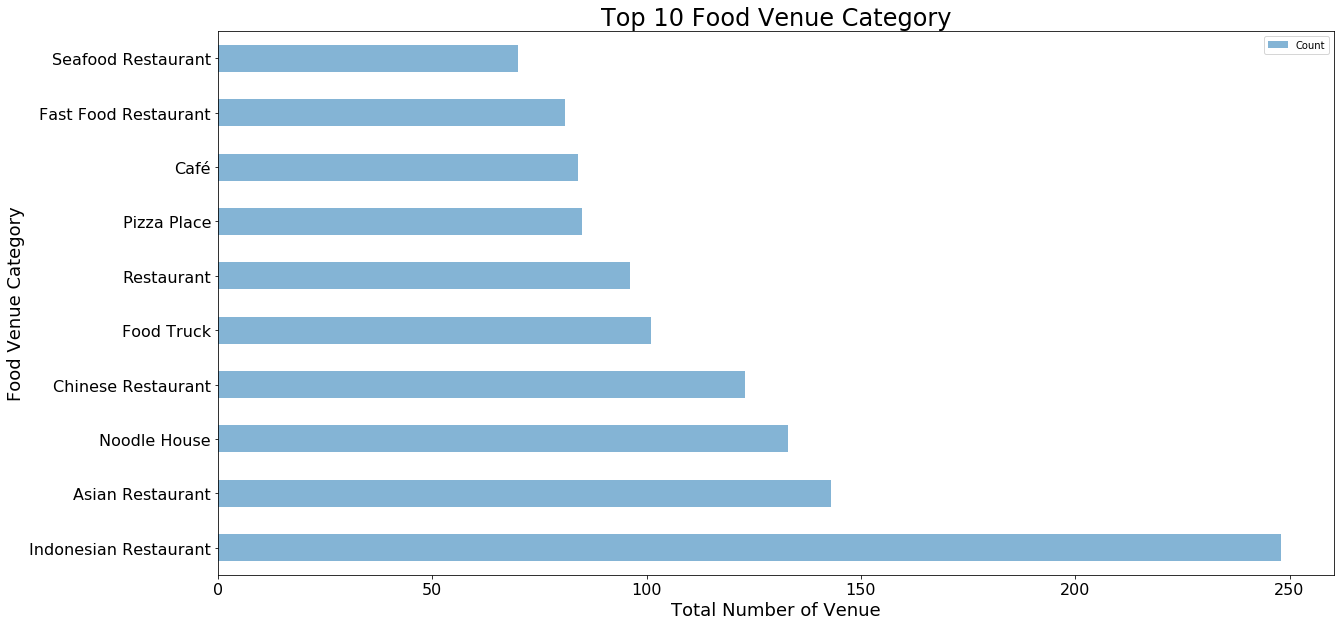

In [17]:
top_10_food_venue_type.plot(kind="barh", alpha=0.55, figsize=(20,10))
plt.title("Top 10 Food Venue Category",fontsize=24)
plt.xlabel("Total Number of Venue", fontsize=18)
plt.ylabel("Food Venue Category",fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

#### 4.5. Cluster All Food Venues

##### 4.5.1. Data Preparation

In [18]:
# one hot encoding
jakarta_onehot = pd.get_dummies(jakarta_food_venues[['Venue_Category']], prefix="", prefix_sep="")

columns = jakarta_onehot.columns

# add neighborhood column back to dataframe
jakarta_onehot['Subdistrict'] = jakarta_food_venues['Subdistrict'] 
jakarta_onehot['Region'] = jakarta_food_venues['Region']
jakarta_onehot['Longitude'] = jakarta_food_venues['Longitude']
jakarta_onehot['Latitude'] = jakarta_food_venues['Latitude']

# move neighborhood column to the first column
fixed_columns = ["Subdistrict", "Region", "Longitude", "Latitude"] + list(columns)
jakarta_onehot = jakarta_onehot[fixed_columns]

jakarta_onehot.head()

,Subdistrict,Region,Longitude,Latitude,Acehnese Restaurant,African Restaurant,American Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,...,Steakhouse,Sundanese Restaurant,Sushi Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,Cakung,Jakarta Timur,106.940109,-6.185562,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Cakung,Jakarta Timur,106.940109,-6.185562,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Cakung,Jakarta Timur,106.940109,-6.185562,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Cakung,Jakarta Timur,106.940109,-6.185562,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Cakung,Jakarta Timur,106.940109,-6.185562,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
jakarta_summed = jakarta_onehot.copy()
jakarta_summed = jakarta_onehot.groupby(by=["Subdistrict", "Longitude", "Latitude"]).sum().reset_index()
jakarta_summed.head()

,Subdistrict,Longitude,Latitude,Acehnese Restaurant,African Restaurant,American Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bakery,...,Steakhouse,Sundanese Restaurant,Sushi Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,Cakung,106.940109,-6.185562,0,0,0,1,0,1,2,...,0,0,0,0,0,0,0,0,0,0
1,Cempaka Putih,106.868548,-6.181214,1,0,0,2,0,2,2,...,0,0,0,0,0,0,0,0,0,0
2,Cengkareng,106.744718,-6.152899,0,0,0,1,0,1,2,...,0,0,0,0,0,0,0,1,0,0
3,Cilandak,106.804863,-6.283818,0,0,0,3,0,0,3,...,1,1,1,0,0,0,0,0,0,1
4,Cilincing,106.944454,-6.129015,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
jakarta_grouped = jakarta_onehot.groupby("Subdistrict").mean().reset_index()
jakarta_grouped.head()

,Subdistrict,Longitude,Latitude,Acehnese Restaurant,African Restaurant,American Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bakery,...,Steakhouse,Sundanese Restaurant,Sushi Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,Cakung,106.940109,-6.185562,0.00,0.0,0.0,0.035714,0.0,0.035714,0.071429,...,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,0.00
1,Cempaka Putih,106.868548,-6.181215,0.02,0.0,0.0,0.040000,0.0,0.040000,0.040000,...,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,0.00
2,Cengkareng,106.744718,-6.152898,0.00,0.0,0.0,0.029412,0.0,0.029412,0.058824,...,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.029412,0.0,0.00
3,Cilandak,106.804863,-6.283818,0.00,0.0,0.0,0.060000,0.0,0.000000,0.060000,...,0.02,0.02,0.02,0.0,0.0,0.0,0.0,0.000000,0.0,0.02
4,Cilincing,106.944454,-6.129015,0.00,0.0,0.0,0.250000,0.0,0.000000,0.000000,...,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,0.00


In [21]:
jakarta_grouped.shape

(42, 81)

In [22]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[3:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [23]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Subdistrict']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Food Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Food Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Subdistrict'] = jakarta_grouped['Subdistrict']

for ind in np.arange(jakarta_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(jakarta_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Subdistrict,1st Most Common Food Venue,2nd Most Common Food Venue,3rd Most Common Food Venue,4th Most Common Food Venue,5th Most Common Food Venue,6th Most Common Food Venue,7th Most Common Food Venue,8th Most Common Food Venue,9th Most Common Food Venue,10th Most Common Food Venue
0,Cakung,Food Truck,Food Court,Restaurant,Indonesian Restaurant,Pizza Place,Chinese Restaurant,Noodle House,Fast Food Restaurant,Bakery,BBQ Joint
1,Cempaka Putih,Pizza Place,Indonesian Restaurant,Restaurant,Café,Seafood Restaurant,Soup Place,Japanese Restaurant,Food Truck,Bakery,BBQ Joint
2,Cengkareng,Food Truck,Café,Noodle House,Pizza Place,Bakery,Fast Food Restaurant,Italian Restaurant,Indonesian Restaurant,Chinese Restaurant,Indonesian Meatball Place
3,Cilandak,Food Truck,French Restaurant,Indonesian Restaurant,Café,Fast Food Restaurant,Padangnese Restaurant,Bakery,Asian Restaurant,Snack Place,Diner
4,Cilincing,Asian Restaurant,Indonesian Restaurant,Diner,Seafood Restaurant,Wings Joint,Fast Food Restaurant,Deli / Bodega,Dim Sum Restaurant,Donut Shop,Dumpling Restaurant


##### 4.5.2. Clustering

In [24]:
# set number of clusters
kclusters = 6

jakarta_grouped_clustering = jakarta_grouped.drop('Subdistrict', 1)

# run k-means clustering
kmeans = k_means(X=jakarta_grouped_clustering, n_clusters=kclusters, random_state=0)

# check cluster labels generated for each row in the dataframe
len(kmeans[1])

42

In [33]:
# add clustering labels
jakarta_clustered = jakarta_summed.copy()
jakarta_clustered.insert(1, 'Cluster Labels', kmeans[1])
jakarta_clustered.head()

,Subdistrict,Cluster Labels,Longitude,Latitude,Acehnese Restaurant,African Restaurant,American Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,...,Steakhouse,Sundanese Restaurant,Sushi Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,Cakung,0,106.940109,-6.185562,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1,Cempaka Putih,0,106.868548,-6.181214,1,0,0,2,0,2,...,0,0,0,0,0,0,0,0,0,0
2,Cengkareng,0,106.744718,-6.152899,0,0,0,1,0,1,...,0,0,0,0,0,0,0,1,0,0
3,Cilandak,5,106.804863,-6.283818,0,0,0,3,0,0,...,1,1,1,0,0,0,0,0,0,1
4,Cilincing,3,106.944454,-6.129015,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


##### 4.5.3. Cluster Visualization

In [34]:
# create map
map_clusters = folium.Map(location=[-6.2088, 106.8456], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(jakarta_clustered['Latitude'], jakarta_clustered['Longitude'], jakarta_clustered['Subdistrict'], jakarta_clustered['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

##### 4.5.4. Cluster Analysis

In [35]:
jakarta_cluster_summary = jakarta_clustered.groupby(by=["Cluster Labels"], axis=0).mean()
jakarta_cluster_summary.drop(columns=["Longitude", "Latitude"], inplace=True)
jakarta_cluster_summary.reset_index(inplace=True)
jakarta_cluster_summary

,Cluster Labels,Acehnese Restaurant,African Restaurant,American Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bakery,Balinese Restaurant,Betawinese Restaurant,...,Steakhouse,Sundanese Restaurant,Sushi Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,0,0.181818,0.090909,0.090909,3.181818,0.000000,0.636364,1.727273,0.000000,0.000000,...,0.909091,0.090909,0.545455,0.000000,0.000000,0.000000,0.090909,0.181818,0.090909,0.000000
1,1,0.000000,0.000000,0.333333,4.222222,0.000000,0.666667,1.000000,0.222222,0.222222,...,0.777778,0.333333,0.555556,0.000000,0.222222,0.000000,0.000000,0.444444,0.000000,0.000000
2,2,0.500000,0.000000,0.333333,6.000000,0.000000,0.166667,0.666667,0.000000,0.000000,...,0.333333,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.166667
3,3,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,4,0.333333,0.000000,0.000000,1.500000,0.000000,0.333333,0.500000,0.000000,0.333333,...,1.000000,0.333333,0.333333,0.000000,0.166667,0.000000,0.166667,0.166667,0.000000,0.166667
5,5,0.000000,0.111111,0.888889,2.666667,0.111111,1.111111,1.888889,0.333333,0.111111,...,1.666667,0.111111,1.777778,0.111111,0.666667,0.222222,0.333333,0.111111,0.222222,0.111111


In [36]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Cluster Label']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Food Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Food Venue'.format(ind+1))

# create a new dataframe
jakarta_cluster_summary_sorted = pd.DataFrame(columns=columns)
jakarta_cluster_summary_sorted['Cluster Label'] = jakarta_cluster_summary['Cluster Labels']

for ind in np.arange(jakarta_cluster_summary.shape[0]):
    jakarta_cluster_summary_sorted.iloc[ind, 1:] = return_most_common_venues(jakarta_cluster_summary.iloc[ind, :], \
                                                                             num_top_venues)

jakarta_cluster_summary_sorted

,Cluster Label,1st Most Common Food Venue,2nd Most Common Food Venue,3rd Most Common Food Venue,4th Most Common Food Venue,5th Most Common Food Venue,6th Most Common Food Venue,7th Most Common Food Venue,8th Most Common Food Venue,9th Most Common Food Venue,10th Most Common Food Venue
0,0,Indonesian Restaurant,Pizza Place,Asian Restaurant,Food Truck,Restaurant,Fast Food Restaurant,Café,Noodle House,Seafood Restaurant,Bakery
1,1,Noodle House,Chinese Restaurant,Asian Restaurant,Indonesian Restaurant,Seafood Restaurant,Food Truck,Pizza Place,Café,Restaurant,Japanese Restaurant
2,2,Indonesian Restaurant,Asian Restaurant,Food Truck,Noodle House,Fast Food Restaurant,Food Court,Café,Restaurant,Pizza Place,Soup Place
3,3,Asian Restaurant,Diner,Indonesian Restaurant,Seafood Restaurant,Wings Joint,Food,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Fast Food Restaurant
4,4,Indonesian Restaurant,Chinese Restaurant,Restaurant,Fast Food Restaurant,Café,Japanese Restaurant,Asian Restaurant,Seafood Restaurant,Noodle House,Indonesian Meatball Place
5,5,Indonesian Restaurant,Japanese Restaurant,Chinese Restaurant,Asian Restaurant,Restaurant,Café,Bakery,Food Truck,Sushi Restaurant,Steakhouse


#### 5. Discussion

#### 6. Conclusion 

#### 7. Future Direction